<a href="https://colab.research.google.com/github/jofmorenore/TS_Climatic/blob/main/R/Data_CHIRPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extracción de datos

In [ ]:
# https://stackoverflow.com/questions/74283327/conversion-py2rpy-not-defined-for-objects-of-type-class-str
!pip install rpy2==3.5.1

In [2]:
#https://stackoverflow.com/questions/67135876/how-many-cpu-cores-does-google-colab-assigns-when-i-keep-n-jobs-8-is-there-an
import multiprocessing

multiprocessing.cpu_count() # Count the number of cores in a computer

2

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%load_ext rpy2.ipython

In [5]:
%%R
getwd()

[1] "/content"


In [6]:
%%R
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

loaded via a namespace (and not attached):
[1] compiler_4.2.3


# Descarga información automatizada raster de CHIRPS haciendo uso de R - SIG

## Librerías

In [ ]:
%%R
if("doSNOW" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("doSNOW"))}
if("foreach" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("foreach"))}
if("mapsf" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("mapsf"))}
if("raster" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("raster"))}
if("rgeos" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("rgeos"))}
if("rgdal" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("rgdal"))}
if("sf" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("sf"))}
if("R.utils" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("R.utils"))}

In [ ]:
%%R
library(doSNOW)
library(dplyr)
library(foreach)
library(lubridate)
library(mapsf)
library(purrr)
library(raster)
library(rgdal)
library(rgeos)
library(R.utils)
library(sf)
library(stringr)

## Descarga del repositorio

In [ ]:
%%R
# Functions to use --------------------------------------------------------
download_chirps <- function(year){
  
  print(year)
  dates <- seq(as.Date(paste0(year, "-01-01")), as.Date(paste0(year, "-12-31")), by="months")
  #dates <- gsub('-', '.', as.character(dates))
  dates <- paste(year(dates), ifelse(month(dates)<10, paste0(0,month(dates)), month(dates)), sep ='.')
  paths <- paste0(pth, '/chirps-v2.0.', dates, '.tif.gz')
  
  lapply(1:length(paths), function(k){
    download.file(url = paths[k],
                  destfile = paste0('./chirps/', basename(paths[k])),
                  mode = 'wb')
  })
}

In [ ]:
%%R
# Load data ---------------------------------------------------------------
#pth <- 'ftp://ftp.chg.ucsb.edu/pub/org/chg/products/CHIRPS-2.0/global_daily/tifs/p05/'
#pth <- 'https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/tifs/p05/'
pth <- 'https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_monthly/tifs/'
dir.create('./chirps/', recursive = TRUE)

In [ ]:
%%R
yrs <- 1981:2022
map(.x = yrs, .f = download_chirps)

## Descomprimir los raster

In [ ]:
%%R
# https://stackoverflow.com/questions/65404992/decompress-tif-gz-file-using-r
chirps <- list.files('./chirps', full.names = TRUE, pattern = '.tif.gz$') 
dir.create('./chirps/stack/', recursive = TRUE)
lapply(1:length(chirps), function(k){
    R.utils::gunzip(filename = chirps[k],
                    destname = paste0('./chirps/stack/', basename(gsub('.gz', '',chirps[k]))),
                    remove = FALSE)
  })

## Recortar y enmascarar para Colombia

In [ ]:
%%R
# Functions to use --------------------------------------------------------
extract_mask <- function(year){
  
  print(year)
  fle <- grep(year, fles, value = TRUE)
  
  print('To extract by mask')
  cl <- makeCluster(2)
  registerDoSNOW(cl)
  
  foreach(i = 1:length(fle), .verbose = TRUE) %dopar% {
    print(paste("mes", i))  
    #shpf <- shapefile('//dapadfs/workspace_cluster_9/Coffee_Cocoa2/_coffeeColombia/shp/base/MGN_DPTO_POLITICO.shp')
    shpf <- shapefile('/content/drive/MyDrive/Curso/MGN_DPTO_POLITICO.shp')
    rst <- raster::raster(fle[i])
    rst <- raster::crop(rst, shpf)
    rst <- raster::mask(rst, shpf)
    rst <- rst * 1
    out <- '/content/drive/MyDrive/Time_Series_climatic_variebles/chirps/colombia/'
    writeRaster(rst, filename = paste0(out, basename(fle[i])), overwrite = TRUE)
    
  }
  
  stopCluster(cl)
  print(paste0('Done ', year))  
  
}

In [ ]:
%%R
# Load data ---------------------------------------------------------------
root <- './chirps/stack'
fles <- list.files(root, full.names = TRUE, pattern = '.tif$')

# Get the years available--------------------------------------------------
years <- unique(str_sub(basename(fles), start = 13, end = 16))

## Exportar al Drive

In [ ]:
%%R
dir.create('/content/drive/MyDrive/Time_Series_climatic_variebles/chirps/colombia/', recursive = TRUE)

In [ ]:
%%R
# To extract by mask for only Colombia ------------------------------------
library(raster)
for(j in 1:length(years)){
  print(years[j])
  extract_mask(year = years[j])
  print(' Done')
}

## Cargar Chirps

### Librerías

In [ ]:
%%R
if("terra" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("terra"))}
if("sf" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("sf"))}
if("doSNOW" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("doSNOW"))}
if("foreach" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("foreach"))}
if("openxlsx" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("openxlsx"))}

In [153]:
%%R
library(dplyr)
library(lubridate)
library(sf)
library(stringr)
library(terra)
library(foreach)
library(doSNOW)
library(ggplot2)
library(readr)
library(openxlsx)

### Raster Data

In [9]:
%%R
chirps <- list.files('/content/drive/MyDrive/Time_Series_climatic_variebles/chirps/colombia', full.names = TRUE, pattern = '.tif$') 
tail(chirps)

[1] "/content/drive/MyDrive/Time_Series_climatic_variebles/chirps/colombia/chirps-v2.0.2022.07.tif"
[2] "/content/drive/MyDrive/Time_Series_climatic_variebles/chirps/colombia/chirps-v2.0.2022.08.tif"
[3] "/content/drive/MyDrive/Time_Series_climatic_variebles/chirps/colombia/chirps-v2.0.2022.09.tif"
[4] "/content/drive/MyDrive/Time_Series_climatic_variebles/chirps/colombia/chirps-v2.0.2022.10.tif"
[5] "/content/drive/MyDrive/Time_Series_climatic_variebles/chirps/colombia/chirps-v2.0.2022.11.tif"
[6] "/content/drive/MyDrive/Time_Series_climatic_variebles/chirps/colombia/chirps-v2.0.2022.12.tif"


In [10]:
%%R
chirps <- terra::rast(chirps)
chirps

class       : SpatRaster 
dimensions  : 353, 298, 504  (nrow, ncol, nlyr)
resolution  : 0.05, 0.05  (x, y)
extent      : -81.75, -66.85, -4.250001, 13.4  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 (EPSG:4326) 
sources     : chirps-v2.0.1981.01.tif  
              chirps-v2.0.1981.02.tif  
              chirps-v2.0.1981.03.tif  
              ... and 501 more source(s)
names       : chirp~81.01, chirp~81.02, chirp~81.03, chirp~81.04, chirp~81.05, chirp~81.06, ... 
min values  :  -9999.0000,  -9999.0000,  -9999.0000,  -9999.0000,   -9999.000,  -9999.0000, ... 
max values  :    677.3947,    795.7532,    752.9749,    944.5653,    1483.174,    934.6393, ... 


In [11]:
%%R
#--- converting to a data.frame ---#
chirps_df <- as.data.frame(chirps, xy = TRUE) # this works with Raster* objects as well
print(head(chirps_df[,1:5]))
print(paste(rep('.',80), collapse = ''))
print(tail(chirps_df[,c(1,2,505:506)]))

           x      y chirps-v2.0.1981.01 chirps-v2.0.1981.02 chirps-v2.0.1981.03
5067 -81.725 12.525           52.069359            26.44028          15.8991852
5863 -71.725 12.425           11.745375            37.81181           5.3487139
5865 -71.625 12.425            5.190650            20.21614           0.5644872
5866 -71.575 12.425            4.368718            14.71338           0.5129853
5867 -71.525 12.425            5.244236            10.91335           0.3851539
6161 -71.725 12.375            9.055499            42.63746           3.1894126
[1] "................................................................................"
             x         y chirps-v2.0.2022.11 chirps-v2.0.2022.12
104238 -69.975 -4.075001            331.2895            290.4229
104239 -69.925 -4.075001            340.8881            305.4037
104535 -70.025 -4.125001            328.9645            299.4938
104536 -69.975 -4.125001            344.4142            306.3362
104537 -69.925 -4.125001    

In [12]:
%%R
chirps.point <- st_as_sf(x = chirps_df, 
                         coords = c("x", "y"),
                         crs = terra::crs(chirps))
                         #crs = "+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0")

terra::crs(chirps)

[1] "GEOGCRS[\"WGS 84\",\n    DATUM[\"World Geodetic System 1984\",\n        ELLIPSOID[\"WGS 84\",6378137,298.257223563,\n            LENGTHUNIT[\"metre\",1]]],\n    PRIMEM[\"Greenwich\",0,\n        ANGLEUNIT[\"degree\",0.0174532925199433]],\n    CS[ellipsoidal,2],\n        AXIS[\"geodetic latitude (Lat)\",north,\n            ORDER[1],\n            ANGLEUNIT[\"degree\",0.0174532925199433]],\n        AXIS[\"geodetic longitude (Lon)\",east,\n            ORDER[2],\n            ANGLEUNIT[\"degree\",0.0174532925199433]],\n    ID[\"EPSG\",4326]]"


In [13]:
%%R
library(readxl)
pcp_col = read_excel('/content/drive/MyDrive/Time_Series_climatic_variebles/pcp_col.xlsx')
tmed_col = read_excel('/content/drive/MyDrive/Time_Series_climatic_variebles/tmed_col2.xlsx', sheet = 'Data')

In [14]:
%%R
sttns = dplyr::distinct(pcp_col, `X` , `Y`) %>% 
  dplyr::full_join(dplyr::distinct(tmed_col, `X` , `Y`), by=c("X" , "Y")) 

sttns.points <- st_as_sf(x = sttns, 
                         coords = c("X", "Y"),
                         crs = terra::crs(chirps)) 
                         #crs = 4326)

print(head(sttns.points))

Simple feature collection with 6 features and 0 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -81.70389 ymin: 10.44725 xmax: -72.91769 ymax: 13.35
Geodetic CRS:  WGS 84
# A tibble: 6 × 1
              geometry
           <POINT [°]>
1 (-81.70389 12.58694)
2       (-81.35 13.35)
3 (-74.22889 11.12833)
4 (-75.51603 10.44725)
5 (-74.77978 10.88334)
6 (-72.91769 11.52822)


In [15]:
%%R
#--- spatial join ---#
chirps_sttns <- st_join(sttns.points, chirps.point[1])
print(dim(chirps_sttns))
print(head(sapply(chirps_sttns, function(x) sum(is.na(x)))))

[1] 856   2
           geometry chirps-v2.0.1981.01 
                  0                 856 


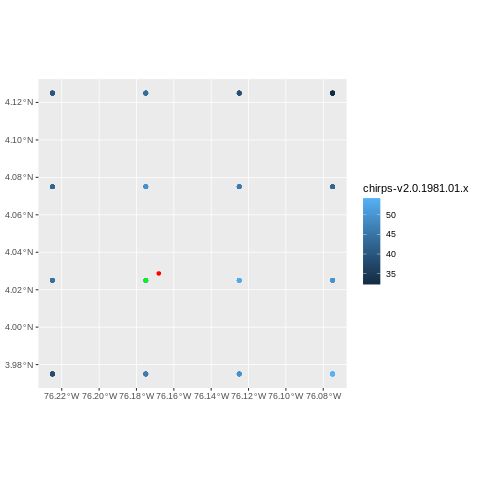

In [ ]:
%%R
set.seed(123)
n = sample(1:nrow(sttns.points), 1)
pt = sttns.points[n,]

pol = data.frame(matrix(c(pt$geometry[[1]] +c(-0.1,-0.1),
         pt$geometry[[1]] +c(-0.1,0.1),
         pt$geometry[[1]] +c(0.1,0.1),
         pt$geometry[[1]] +c(0.1,-0.1)
         ), nc = 2, byrow = F))
names(pol) = c("X", "Y")
pol = pol %>%
  st_as_sf(coords = c("X", "Y"), crs = 4326) %>%
  summarise(geometry = st_combine(geometry)) %>%
  st_cast("POLYGON")

chirps_1981_01 = filter(chirps.point[1],`chirps-v2.0.1981.01`>0)

join_chirps_pol = st_join(pol, chirps_1981_01)
chirps_1981_01 = st_join(chirps_1981_01, join_chirps_pol)
chirps_1981_01 = filter(chirps_1981_01, !is.na(`chirps-v2.0.1981.01.y`)) %>% 
                  select(-`chirps-v2.0.1981.01.y`)

ggplot() + 
   geom_sf(data = chirps_1981_01, aes(fill = `chirps-v2.0.1981.01.x`, col = `chirps-v2.0.1981.01.x`)) +
   geom_sf(data = pt, fill = NA, col = 'red', lwd = 0.2) +
   geom_sf(data = chirps.point[1][st_nearest_feature(sttns.points[n,], chirps.point[1]),], fill = NA, col = 'green', lwd = 0.2 )
  #geom_sf(data = chirps_1981_01, aes(fill = `chirps-v2.0.1981.01`, col = `chirps-v2.0.1981.01`))+
  #geom_sf(data = sttns.points, fill = NA, col = 'grey70', lwd = 0.2)

In [16]:
%%R
chirps_sttns = sttns

# https://stackoverflow.com/questions/49200458/find-nearest-features-using-sf-in-r
for(i in 1:length(chirps.point)){
    chirps_sttns[[names(chirps.point[i])[1]]] = chirps.point[i][st_nearest_feature(sttns.points, chirps.point[i]),][[1]]    
}

print(dim(chirps_sttns))
print(head(chirps_sttns[,1:6]))
print(paste(rep('.',80), collapse = ''))
print(tail(chirps_sttns[,c(1,2,505:506)]))

[1] 856 507
# A tibble: 6 × 6
      X     Y `chirps-v2.0.1981.01` `chirps-v2.0.1981.02` chirps-v2.0.…¹ chirp…²
  <dbl> <dbl>                 <dbl>                 <dbl>          <dbl>   <dbl>
1 -81.7  12.6                 52.1                  26.4           15.9     29.7
2 -81.4  13.4                 52.1                  26.4           15.9     29.7
3 -74.2  11.1                  6.65                  7.19          31.1    242. 
4 -75.5  10.4                  2.82                  3.90           3.21    61.4
5 -74.8  10.9                  3.24                  3.44          11.0     95.3
6 -72.9  11.5                 10.8                  19.1            1.50   174. 
# … with abbreviated variable names ¹​`chirps-v2.0.1981.03`,
#   ²​`chirps-v2.0.1981.04`
[1] "................................................................................"
# A tibble: 6 × 4
      X     Y `chirps-v2.0.2022.11` `chirps-v2.0.2022.12`
  <dbl> <dbl>                 <dbl>                 <dbl>
1 -74.7  5.4

In [17]:
%%R
paste0(object.size(chirps_sttns)/1000000, " MB")

[1] "3.911952 MB"


In [31]:
%%R
print(table(sapply(chirps_sttns[,3:(ncol(chirps_sttns)-1)], function(x) sum(x<0))))
table(sapply(chirps_sttns[,3:(ncol(chirps_sttns)-1)], function(x) sum(is.na(x))))


  0 
504 

  0 
504 


In [159]:
%%R
write.csv2(chirps_sttns, "/content/drive/MyDrive/Time_Series_climatic_variebles/chirps/Chirps_MetStationsCol_1981_2022.csv", row.names = F, dec = ",")

### plot

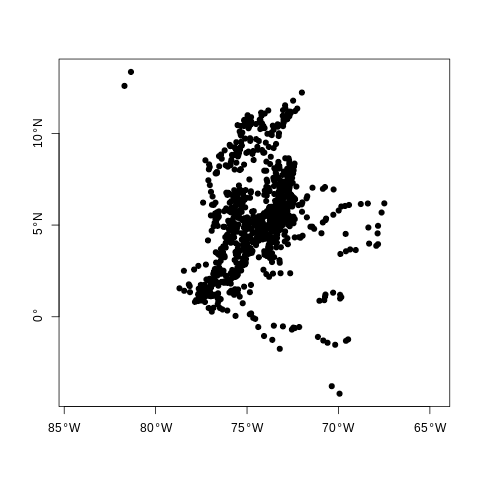

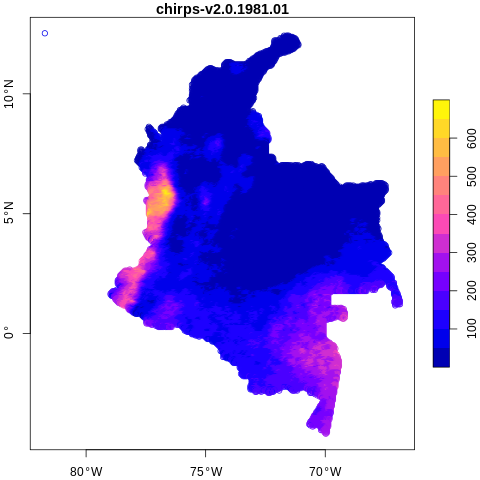

In [145]:
%%R
chirps_1981_01 = filter(chirps.point[1],`chirps-v2.0.1981.01`>0)
plot(sttns.points, pch = 21, bg = 'black', axes = TRUE)
plot(chirps_1981_01, border = 'grey', axes = TRUE)

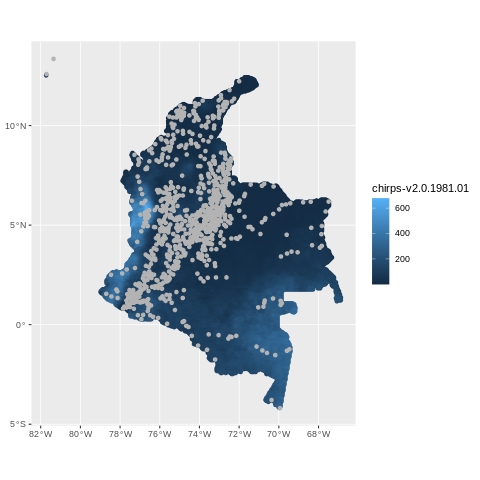

In [58]:
%%R
chirps_1981_01 = filter(chirps.point[1],`chirps-v2.0.1981.01`>0)
ggplot() + 
  geom_sf(data = chirps_1981_01, aes(fill = `chirps-v2.0.1981.01`, col = `chirps-v2.0.1981.01`))+
  geom_sf(data = sttns.points, fill = NA, col = 'grey70', lwd = 0.2)

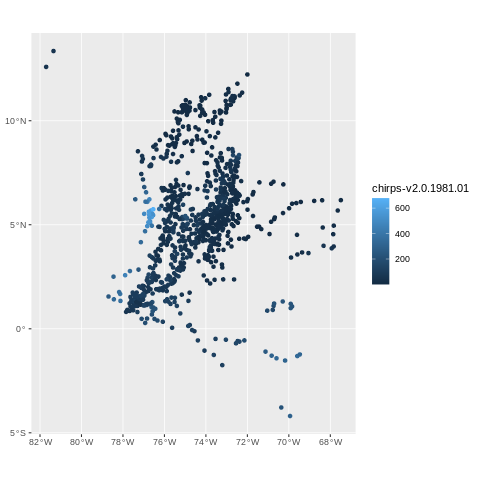

In [65]:
%%R
chirps_sttns %>% st_as_sf(coords = c("X", "Y"), crs = 4326) %>% 
  ggplot() + 
  geom_sf(aes(fill = `chirps-v2.0.1981.01`, col = `chirps-v2.0.1981.01`))

# geodata::worldclim_country

This is WorldClim 2.1 (January 2020) downloaded from http://worldclim.org
They represent average monthly climate data for 1970-2000. 

In [ ]:
%%R
if("geodata" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("geodata"))}

In [ ]:
%%R
library(geodata)
#?geodata::worldclim_country

In [ ]:
%%R
# Download climate
prec <- geodata::worldclim_country(country = 'COL', var = 'prec', path = './tmpr')
tavg <- geodata::worldclim_country(country = 'COL', var = 'tavg', path = './tmpr')

prec <- raster::stack(prec)
tavg <- raster::stack(tavg)

In [ ]:
%%R
prec

class      : RasterStack 
dimensions : 2460, 1860, 4575600, 12  (nrow, ncol, ncell, nlayers)
resolution : 0.008333333, 0.008333333  (x, y)
extent     : -82, -66.5, -4.5, 16  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
names      : COL_wc2.1_30s_prec_1, COL_wc2.1_30s_prec_2, COL_wc2.1_30s_prec_3, COL_wc2.1_30s_prec_4, COL_wc2.1_30s_prec_5, COL_wc2.1_30s_prec_6, COL_wc2.1_30s_prec_7, COL_wc2.1_30s_prec_8, COL_wc2.1_30s_prec_9, COL_wc2.1_30s_prec_10, COL_wc2.1_30s_prec_11, COL_wc2.1_30s_prec_12 
min values :                    0,                    0,                    1,                    0,                    0,                    0,                    0,                    0,                    0,                     0,                     0,                     0 
max values :                  623,                  529,                  570,                  636,                  764,                  745,                  764,                  912,   

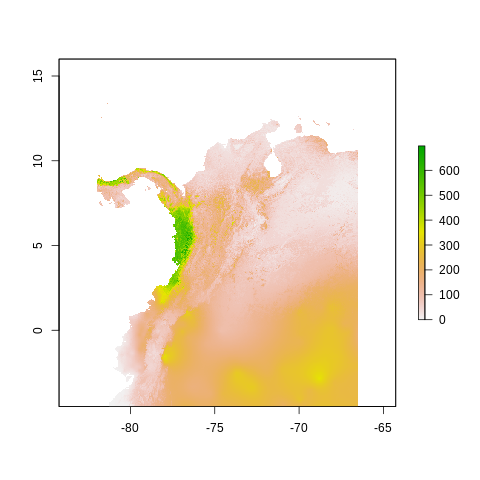

In [ ]:
%%R
plot(prec[[12]]) 

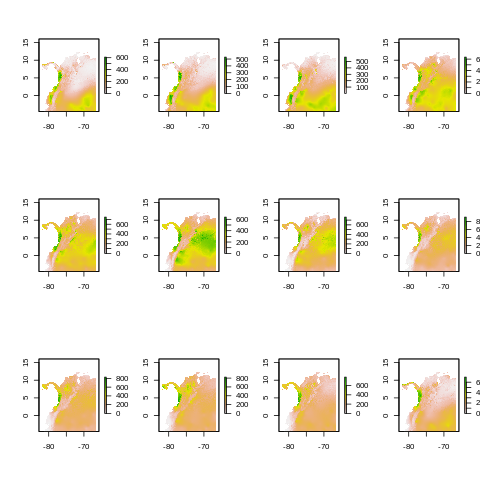

In [ ]:
%%R
par(mfrow=c(3,4))  
for(i in 1:12){
    plot(prec[[i]])    
}

# R.package: chirps

In [ ]:
%%R
install.packages("chirps")

In [ ]:
%%R
installed.packages()[row.names(installed.packages()) %in% "chirps",]

                                                                      Package 
                                                                     "chirps" 
                                                                      LibPath 
                                              "/usr/local/lib/R/site-library" 
                                                                      Version 
                                                                      "0.1.4" 
                                                                     Priority 
                                                                           NA 
                                                                      Depends 
                                                      "R (>= 3.5.0), methods" 
                                                                      Imports 
                               "httr, jsonlite, sf, stats, terra (>= 1.2-10)" 
                                                    

In [ ]:
%%R
library("chirps")
library("sf")

data("tapajos", package = "chirps")

# sample three points within the Tapajos area
set.seed(1234)
tp_point <- st_sample(tapajos, 3)

# coerce as sf points
tp_point <- st_as_sf(tp_point)

In [ ]:
%%R
tp_point

Simple feature collection with 3 features and 0 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -55.03719 ymin: -3.797467 xmax: -54.98543 ymax: -3.206582
Geodetic CRS:  WGS 84
                            x
1 POINT (-55.03719 -3.797467)
2 POINT (-55.02853 -3.206582)
3  POINT (-54.98543 -3.37161)


In [ ]:
%%R
dat <- get_chirps(tp_point,
                  dates = c("1982-01-01","2020-12-31"), 
                  server = "CHC")

In [ ]:
%%R
str(dat)

Classes ‘chirps’, ‘chirps_df’ and 'data.frame':	42735 obs. of  5 variables:
 $ id    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ lon   : num  -55 -55 -55 -55 -55 ...
 $ lat   : num  -3.8 -3.8 -3.8 -3.8 -3.8 ...
 $ date  : Date, format: "1982-01-01" "1982-01-01" ...
 $ chirps: num  0 0 0 46.5 26.8 ...


In [ ]:
%%R
3*length(seq(as.Date(paste0(1982, "-01-01")), as.Date(paste0(2020, "-12-31")), by="days"))

[1] 42735
